Follow up from previously acquired data: /workspace/projects/TES/data/20170316_SQUID1_bandwidth_characterisation
We found that under the conditions 155 mK, Ibias = 300 uA, GBWP = Max, Rf = 100 kOhm, Input Flux Termination @ FLL = Unknown, FLL mode, we had a bandwidth of 1.7 MHz, that explained the ~170 ns pulse rise time.
Antia reported ~25 ns rise time with open loop amplifiers.
Reducing Rf to 30 kOhm resulted in too low SNR.

We would like to investigate the source of noise in the system, with the hope of running our amplifiers with a lower Rf, thereby increasing the bandwidth, reducing the rise time.

First, we calculate the expected Johnson noise when the system is driven to a conducting state at 80 mK, 125 uA (Jan Dreyling-Eschweiler p.96). This decouples the TES from the SQUID input - arguable since the impedance change will only be 50%...
    Then, we calculate the current noise at this operating point, which will also contribute to overall noise.
    This determines the input spectrum to the SQUID.
    Thereafter, we drive the TES superconducting (125 uA), then conducting (0uA), and compare the noise spectrum collected.
    IV Curves are included to prove that 125uA are sufficient to drive the TES conducting at 125uA.
    
Second, we send a nominal operating current 110 uA, which was verified to have a good SNR.
    Then, we change the gain of the system by adjusting Rf, keeping the GBP constant. This should increase the bandwidth and the noise. 
    We verify if the bw increased by comparing the f-3db cutoff frequency.

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
%matplotlib inline

## Noise Comparison between Superconducting and Conducting Operation

In [138]:
SupCond_Noise = np.loadtxt('./superconducting_vs_conducting_noise_spectrums/0uArbw30khzvbw300khz10avg.txt', skiprows=46)
Cond_Noise = np.loadtxt('./superconducting_vs_conducting_noise_spectrums/125uArbw30khzvbw300khz10avg.txt', skiprows=46)

In [224]:
def convert_units(unit):
    """invert dBm equation to current through 50 Ohm R&S"""
    def new_spectrum(spectrum):
        def wrapper(noise_array):
            r = 50 #ohms
            bins, power_dbm = spectrum(noise_array)
            power = 1e-3*10**(power_dbm/10)
            if unit == 'amps':
                return bins, np.sqrt(power/r)
            if unit == 'volts':
                return bins, np.sqrt(power*r)
            if unit == 'watts':
                return bins, power
        return wrapper
    return new_spectrum

def spectral_density(spectrum):
    """convert spectrum into spectral density"""
    def wrapper(noise_array):
        bins, data = spectrum(noise_array)
        bin_size = bins[1]-bins[0]
        return bins, data/bin_size
    return wrapper
    
def iTES_from_vOut():
    """converts voltage output """
    pass

@spectral_density
@convert_units('watts')
def spectrum(noise_array):
    """returns the noise density in Watts(default)"""
    bins = noise_array[:,0]
    power_dbm = noise_array[:,1]
    return np.array(bins), np.array(power_dbm)

def f3dB(noise_array, plot=False, color='blue'):
    """finds and plots 3dB-cuttoff frequency"""
    def quick_hor(value,label,color):
        """plots horizontal level"""
        plt.axhline(value,label=label,linestyle='--',color=color)
    def quick_vert(value,label,color):
        """plots vertical level"""
        plt.axvline(value,label=label,linestyle='--',color=color)
        
    bins, density = spectrum(noise_array)
    mask=(bins>1e5)&(bins<0.8e6)
    max_density = np.max(density[mask])

    median_density = np.median(density[mask]) #estimates the density before 3dB falloff
    
    def find_idx(array,value):
        """finds index of array closest to value"""
        return np.argmin(np.abs(array-value))
    density_at_f3dB = median_density/2
    
    f3dB = bins[find_idx(density[:np.argmin(density)],density_at_f3dB)]
    if plot:
        quick_vert(f3dB, 'f3dB',color)
        quick_hor(median_density, 'median', color)
        quick_hor(density_at_f3dB, '3dB',color)
    return f3dB/1e6

2.42857142857
0.0952380952381


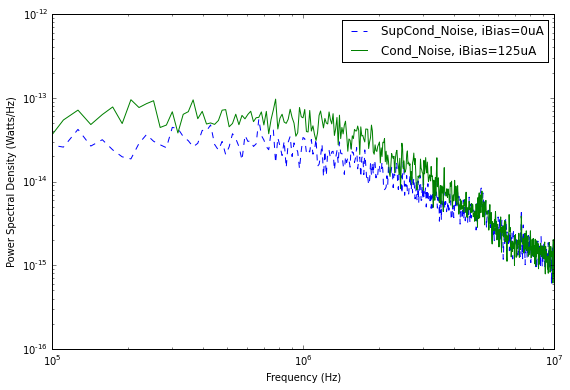

In [225]:
plt.figure(figsize=(9,6))
plt.plot(*spectrum(SupCond_Noise), label='SupCond_Noise, iBias=0uA',linestyle='--')
plt.plot(*spectrum(Cond_Noise), label='Cond_Noise, iBias=125uA')
print(f3dB(SupCond_Noise))
print(f3dB(Cond_Noise))
plt.semilogx()
plt.semilogy()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (Watts/Hz)')
plt.ylim(1e-16,1e-12)
plt.xlim(100e3,1e7) #R&S FSH8 only operates 100kHz onwards
plt.legend()
plt.tight_layout
plt.savefig('superconducting_vs_conducting_noise.pdf')
plt.show()

## IV Curve of SQUID 1

## Bandwidth Comparison of TES 5, SQUID 1, with different feedback resistances

TES bias = 104 uA, T = 80 mK corresponding to good single photon signal to noise ratio.
Input Flux Termination @ FLL = OFF
SQUID Gain = Positive

f3dB=1.33333333333MHz
f3dB=1.28571428571MHz


<function matplotlib.pyplot.tight_layout>

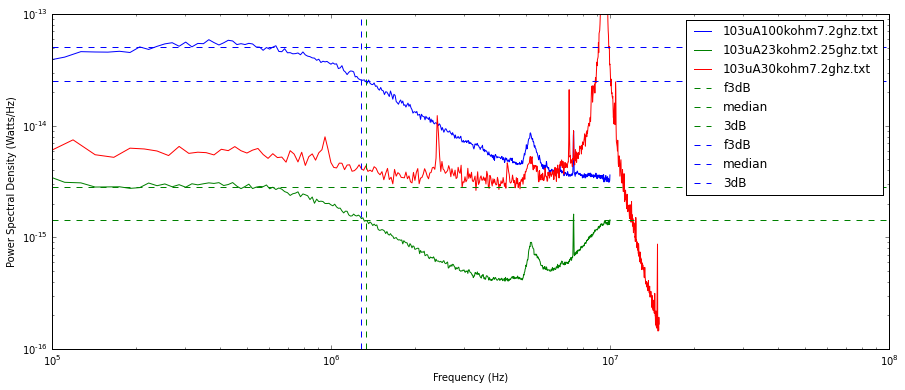

In [219]:
import glob
folder = './various_RFeedback_vs_GBP_ratios_noise_spectrums_IBias_104uA_80mK/'
plt.figure('Various Rf vs GBP')
plt.figure(figsize=(15,6))
for trace in glob.glob(folder+'*.txt'):
    plt.plot(*spectrum(np.loadtxt(trace,skiprows=46)),
        label=trace.split('/')[-1])
print 'f3dB={}MHz'.format(f3dB(np.loadtxt(folder+'103uA23kohm2.25ghz.txt',skiprows=46),plot=True,color='green'))
print 'f3dB={}MHz'.format(f3dB(np.loadtxt(folder+'103uA100kohm7.2ghz.txt',skiprows=46),plot=True,color='blue'))

plt.semilogx()
plt.semilogy()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (Watts/Hz)')
plt.ylim(1e-16,1e-13)
plt.xlim(100e3,) #R&S FSH8 only operates 100kHz onwards
plt.legend()
plt.tight_layout

We observe that the f3dB ratios are approximately 4% different.
Whereas the Rf/GBP ratio is expected to be 25% different.